In [1]:
import numpy as np
import pandas as pd
import pickle
import scipy.sparse

## merging little files

In [2]:
with open("../../data/gene_dict.pkl", 'rb') as f:
	gene_dict = pickle.load(f)

In [3]:
gene_dict

{'B2M': 0,
 'CCR10': 1,
 'CD58': 2,
 'CD59': 3,
 'CDH19': 4,
 'CDK4': 5,
 'CDK6': 6,
 'CTSA': 7,
 'CTSB': 8,
 'CTSD': 9,
 'CXCR4': 10,
 'DNMT1': 11,
 'EIF3K': 12,
 'FOS': 13,
 'HLA-A': 14,
 'HLA-B': 15,
 'HLA-C': 16,
 'HLA-E': 17,
 'IFNGR1': 18,
 'IFNGR2': 19,
 'IRF3': 20,
 'LAMP2': 21,
 'MYC': 22,
 'NGFR': 23,
 'NPC1': 24,
 'NPC2': 25,
 'RB1': 26,
 'SAT1': 27,
 'SEC11C': 28,
 'SERPINE2': 29,
 'SMAD4': 30,
 'SOX4': 31,
 'SP100': 32,
 'STAT1': 33,
 'STAT3': 34,
 'TGFB1': 35}

In [4]:
data = {}

In [5]:
import glob

for file in glob.glob("../../data/samples+/*npy"):
	f = file.split("/")[-1].split(".")[0]
	with open(file, 'rb') as file:
		data[f] = np.load(file)

In [6]:
mean = np.average(data['ctrl'], axis=1)

In [48]:
data_new = {}
for k in data.keys():
	if k == 'ctrl':
		data_new[k] = (np.zeros(36), data[k].shape[1], np.mean(data[k], axis=1), data[k])
	else:
		new_k = np.zeros(36)
		for g in k.split("_")[1:]:
			new_k[gene_dict[g]] = - mean[gene_dict[g]]
		data_new[k] = (new_k, data[k].shape[0], np.mean(data[k].T, axis=1), data[k].T)

In [49]:
with open("../../data/data+.pkl", 'wb') as file:
	pickle.dump(data_new, file)

## saving little files

In [9]:
ctrl_cells = pd.read_csv("../data/controlscreen_observational_samples_reduced.csv")
genes = ctrl_cells['GENE'].to_numpy()

with open("../save/pertub_dict.pkl", 'rb') as f:
	pertub_dict = pickle.load(f)

In [7]:
ctrl_cells.to_numpy()[:, 1:].astype(float)

array([[7.5192347, 6.6042027, 7.292672 , ..., 6.9177303, 7.1495404,
        6.5190306],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 3.78852  , ..., 0.       , 0.       ,
        4.7346196],
       ...,
       [0.       , 4.819194 , 0.       , ..., 0.       , 0.       ,
        5.0201025],
       [0.       , 4.819194 , 0.       , ..., 4.0440497, 4.219136 ,
        3.6534262],
       [5.272544 , 4.819194 , 5.1576967, ..., 4.0440497, 0.       ,
        4.3335376]])

In [7]:
np.save("../../data/samples+/ctrl.npy", ctrl_cells.to_numpy()[:,1:].astype(float))

In [8]:
# ptb_cells_id = np.concatenate([pertub_dict['Control'][a] if a != '' else [] for a in pertub_dict['Control'].keys()])
# ptb_cells_full = pd.read_csv("../data/RNA_expression.csv", header=0, index_col=0, sep=',',
# 			usecols=np.concatenate([['GENE'], ptb_cells_id]))
# ptb_cells = ptb_cells_full.loc[genes, :]
# ptb_cells.to_csv("../data/controlscreen_interventional_samples_reduced.csv")

In [8]:
all_ptb_cells = []
all_genes = []
header = []

count = 0
with open("../data/RNA_expression.csv") as csv_file:
	for row in csv_file:
		if count == 0:
			header = row.split(',')[1:]
			count += 1
		else:
			row = row.split(',')
			all_genes.append(row[0])
			all_ptb_cells.append(scipy.sparse.csr_matrix(np.array(row[1:], dtype=float)))
 
all_ptb_cells = scipy.sparse.vstack(all_ptb_cells)

In [10]:
all_ptb_cells.T

<218331x23712 sparse matrix of type '<class 'numpy.float64'>'
	with 740736244 stored elements in Compressed Sparse Column format>

In [11]:
ptb_cells_id = np.concatenate([pertub_dict['Control'][a] if a != '' else [] for a in pertub_dict['Control'].keys()])
ptb_cells_idx = [header.index(i) for i in ptb_cells_id]
genes_idx = [all_genes.index(i) for i in genes]

In [16]:
all_ptb_cells_reduced = all_ptb_cells.T[:, genes_idx]

In [10]:
selected_ptbs = []
selected_samples = {}
for a in pertub_dict['Control'].keys():
	if all(i in genes for i in a.split('_')):
		selected_ptbs.append(a)
	if any(i in genes for i in a.split('_')):
		key = '_'.join([i for i in a.split('_') if i in genes])
		if key in selected_samples.keys():
			selected_samples[key].append(a)
		else:
			selected_samples[key] = [a]

In [9]:
from tqdm import tqdm

In [10]:
all_ptb_cells_reduced.shape

NameError: name 'all_ptb_cells_reduced' is not defined

In [23]:
for a in tqdm(selected_ptbs):
	ptb_cells_idx = []
	for b in selected_samples[a]:
		ptb_cells_idx += [header.index(i) for i in pertub_dict['Control'][b]]
	subset = all_ptb_cells_reduced[ptb_cells_idx, :].toarray()
	np.save(f"../../data/samples+/ptb_{a}.npy", subset)


100%|██████████| 253/253 [00:06<00:00, 39.19it/s]


In [112]:
with open("../data/ptb_list.pkl", 'wb') as file:
	pickle.dump(selected_ptbs, file)

## sample size

In [11]:
ptb_cells_nums = [len(pertub_dict['Control'][a]) for a in selected_ptbs]

In [12]:
sorted_selected_ptbs = sorted(selected_ptbs, key=lambda x: x.split('_').__len__())

/tmp/ipykernel_26448/1821789502.py:10: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([]);


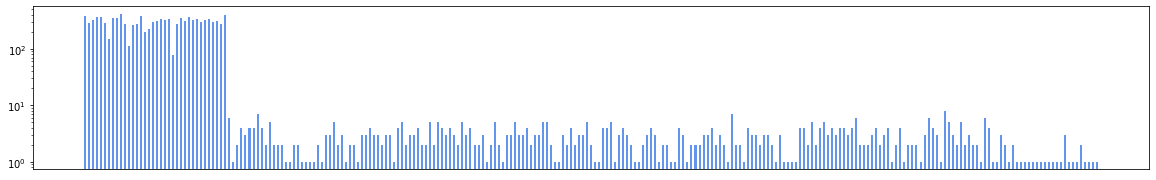

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,3))
plt.yscale('log')
sorted_ptb_cells_nums = []
for a in sorted_selected_ptbs:
	sorted_ptb_cells_nums.append(np.sum([len(pertub_dict['Control'][b]) for b in selected_samples[a]]))
	
plt.bar(sorted_selected_ptbs,  sorted_ptb_cells_nums, color='cornflowerblue', width=.5);
plt.xticks([]);

In [14]:
int_cell_nums = {}

for ptb, cnum in zip(sorted_selected_ptbs, sorted_ptb_cells_nums):
	l = len(ptb.split('_'))
	try:
		int_cell_nums[l].append(cnum)
	except:
		int_cell_nums[l] = [cnum]

sorted_cell_num = []
for l in sorted(int_cell_nums.keys()):
	sorted_cell_num += list(sorted(int_cell_nums[l], reverse=True))


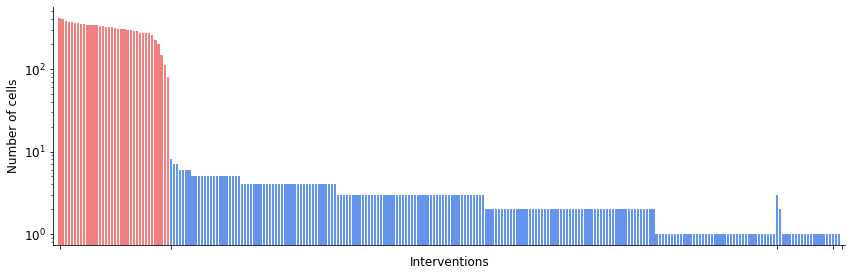

In [32]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
plt.rcParams.update({'font.size': 12})
plt.yscale('log')
plt.bar(np.arange(len(sorted_cell_num))+1, sorted_cell_num, color=['lightcoral']*len(int_cell_nums[1])+['cornflowerblue']*(len(sorted_cell_num)-len(int_cell_nums[1])), width=0.75, alpha=1)

tick = [1]
tick_label = ['']
for l in sorted(int_cell_nums.keys()):
	tick.append(tick[-1]+len(int_cell_nums[l]))
	tick_label.append('')
plt.xticks(tick, rotation=90, labels=tick_label);
plt.xlim(-1, 255)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.ylabel('Number of cells')
plt.xlabel('Interventions')
plt.tight_layout()
plt.savefig('../../figures/bar_samples.pdf')

In [78]:
cell_nums = {}

for ptb, cnum in zip(sorted_selected_ptbs, sorted_ptb_cells_nums):
	l = len(ptb.split('_'))
	try:
		cell_nums[l] += cnum
	except:
		cell_nums[l] = cnum


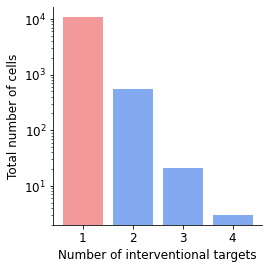

In [92]:
fig, ax = plt.subplots(1,1,figsize=(3.9,3.9))
plt.rcParams.update({'font.size': 12})
plt.yscale('log')
plt.bar(cell_nums.keys(), cell_nums.values(), color=['lightcoral']+['cornflowerblue']*3, alpha=0.8)
plt.xticks([1,2,3,4])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlabel('Number of interventional targets')
plt.ylabel('Total number of cells')
plt.tight_layout()
plt.savefig('../../figures/bar_totalsample.pdf')

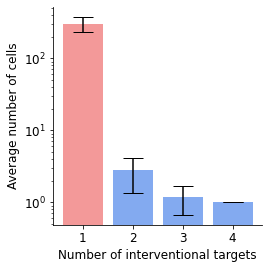

In [91]:
fig, ax = plt.subplots(1,1,figsize=(3.9,3.9))
plt.rcParams.update({'font.size': 12})
plt.yscale('log')
plt.bar(int_cell_nums.keys(), [np.average(l) for l in int_cell_nums.values()], yerr=[np.std(l) for l in int_cell_nums.values()], capsize=10, color=['lightcoral']+['cornflowerblue']*3, alpha=0.8)
plt.xticks([1,2,3,4])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlabel('Number of interventional targets')
plt.ylabel('Average number of cells')
plt.tight_layout()
plt.savefig('../../figures/bar_avgsample.pdf')

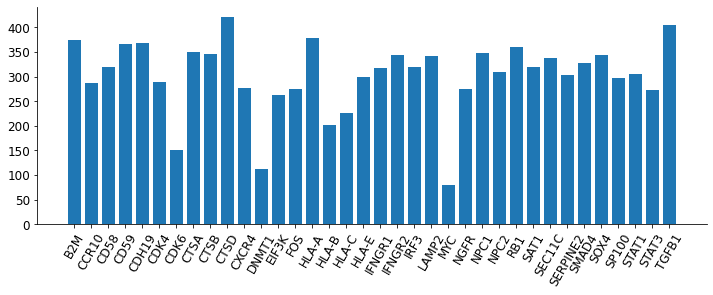

In [96]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
plt.rcParams.update({'font.size': 12})
plt.bar(sorted_selected_ptbs[0:36],  sorted_ptb_cells_nums[0:36]);
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xticks(rotation=60);


In [97]:
for ptb, num in zip(sorted_selected_ptbs[0:36], sorted_ptb_cells_nums[0:36]):
	print(ptb, num)

B2M 375
CCR10 287
CD58 320
CD59 366
CDH19 369
CDK4 289
CDK6 150
CTSA 351
CTSB 346
CTSD 421
CXCR4 276
DNMT1 113
EIF3K 262
FOS 275
HLA-A 378
HLA-B 202
HLA-C 227
HLA-E 300
IFNGR1 318
IFNGR2 343
IRF3 320
LAMP2 342
MYC 79
NGFR 275
NPC1 349
NPC2 309
RB1 361
SAT1 319
SEC11C 337
SERPINE2 303
SMAD4 328
SOX4 343
SP100 298
STAT1 306
STAT3 273
TGFB1 405


In [15]:
# import matplotlib.pyplot as plt

# sorted_ptb_cells_nums = [len(pertub_dict['Control'][a]) for a in sorted_selected_ptbs]
# plt.bar(sorted_selected_ptbs,  sorted_ptb_cells_nums);

In [16]:
for i in np.where(np.array(sorted_ptb_cells_nums) >= 10)[0]:
	k = sorted_selected_ptbs[i]
	if '_' in k:
		print(k)

In [ ]:
# scipy.sparse.save_npz("../data/controlscreen_interventional_samples.npz", all_ptb_cells)